# Lotka Volterra UPINN

In [4]:
import torch
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import pysindy as ps
from kan import KAN

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../../utils')
from upinn import UPINN
from architectures import FNN, ResNet
from LotkaVolterraData import LotkaVolterraData
from utils import SINDy_sklearn, sample_collocation_points

Consider the Lotka-Volterra equations, which describe the dynamics of a predator-prey system:

\begin{align}
\frac{dx}{dt} &= \alpha x - \beta x y, \\
\frac{dy}{dt} &= - \delta y + \gamma x y,
\end{align}

where $x$ is the number of prey, $y$ is the number of predators, and $\alpha$, $\beta$, $\gamma$, and $\delta$ are positive constants.

## Generate Data from System

In [5]:
time_int = [0, 20]

In [6]:
# Boundary conditions
tbc = torch.tensor([[0.0]])
Xbc = torch.tensor([1.0, 1.0]).reshape(-1, 2)

In [7]:
# Collocation points
N_coll = 1000
Xc = sample_collocation_points(N_coll, 1, lb=[time_int[0]], ub=[time_int[1]], method='grid')

### Known system $N_K$

Assume that $\gamma x y$ is not known, and we want to learn it from data.

In [8]:
class LV(torch.nn.Module):
    
    def __init__(self, params):
        super(LV, self).__init__()
        self.alpha = params['alpha']
        self.beta = params['beta']
        self.delta = params['delta']
        self.gamma = params['gamma']

    def forward(self, z, U):

        dUdt = torch.cat([
        torch.autograd.grad(outputs=U[:, i], inputs=z, grad_outputs=torch.ones_like(U[:, i]), create_graph=True)[0]
        for i in range(U.shape[1])
        ], dim=-1)

        return torch.stack([
            dUdt[:, 0] - alpha*U[:, 0] + beta*U[:, 0]*U[:, 1],
            dUdt[:, 1] + delta*U[:, 1] - gamma*U[:, 0]*U[:, 1]
        ], dim=-1)

alpha, beta, gamma, delta = 2/3, 4/3, 1.0, 1.0
params = dict(
    alpha=alpha,
    beta=beta,
    delta=delta,
    gamma=gamma
)

data = LotkaVolterraData(Xbc, alpha, beta, gamma, delta, time_int)

N = LV(params)

### Problem specific UPINN functions

In [9]:
class LV_UPINN(UPINN):

    def score(self):
        u_pred = self.u(data.t_full)
        return torch.nn.MSELoss()(u_pred, data.X_full)
    

    def plot(self, save=None):
        
        self.to('cpu')

        with torch.no_grad():
            t_plot = data.t_full
            x_true = data.X_full[:, 0:1]
            y_true = data.X_full[:, 1:2]

            u_pred = self.u(t_plot)
            
            x_pred = u_pred[:, 0]
            y_pred = u_pred[:, 1]

            plt.plot(t_plot, x_pred, 'r', label='Predator')
            plt.plot(t_plot, y_pred, 'b', label='Prey')
            plt.plot(t_plot, x_true, 'r--')
            plt.plot(t_plot, y_true, 'b--')
            plt.xlabel('t')
            plt.legend()

            if save is not None:
                plt.savefig(save+'pdf', format='pdf', bbox_inches='tight')

            plt.show()


### Setup UPINN

In [10]:
# Define model architectures
hidden = [16] * 4
u = FNN(
    dims=[1, *hidden, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.SiLU(),
)

In [11]:
upinn = LV_UPINN(u, N, boundary_points=(tbc, Xbc), collocation_points=Xc)

[Info]: Initializing PINN model (Residual network F unspecified; Setting F to 0.0)


In [22]:
# Count number of parameters
print('Number of parameters:', sum(p.numel() for p in u.parameters() if p.requires_grad))

Number of parameters: 886


In [24]:
print('Number of parameters:', sum(p.numel() for p in u.parameters() if p.requires_grad))

Number of parameters: 112


### Train

In [11]:
# adamw = torch.optim.AdamW(upinn.parameters(), lr=1e-3, weight_decay=1e-4)
# upinn.optimizer = adamw

# for i in range(time_int[1]):
#     upinn.collocation_points = sample_collocation_points(1000, 1, lb=[time_int[0]], ub=[i+1], method='grid').requires_grad_(True)
#     loss, _, _, _ = upinn.get_loss()
#     while loss.item() > 1e-5:
#         upinn.train_loop(500)
#         loss, _, _, _ = upinn.get_loss()
#     upinn.plot()

In [12]:
# upinn.save('lv_pinn_forward', 'models')
upinn.load('lv_pinn_forward', 'models')

In [98]:
adamw = torch.optim.AdamW(upinn.parameters(), lr=1e-5, weight_decay=1e-4)
upinn.optimizer = adamw
upinn.train_loop(5000)

[Info]: Training 5000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 5000/5000 [01:06<00:00, 74.75 epoch/s, loss=3.53e-07, bc_loss=7.97e-10, data_loss=0.00e+00, pde_loss=3.52e-07]


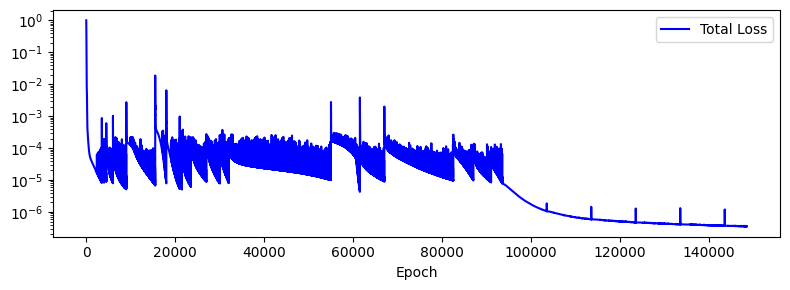

In [107]:
plt.figure( figsize=(8, 3) )
plt.plot(upinn.log['loss'], color='b', label='Total Loss')
plt.yscale('log')
plt.legend()
plt.xlabel('Epoch')
plt.tight_layout()
plt.savefig('gfx/lv-pinn-loss.pdf', format='pdf', bbox_inches='tight')
plt.show()

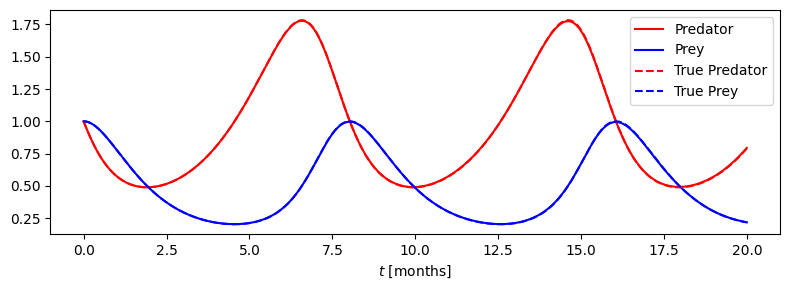

In [13]:
plt.figure( figsize=(8, 3) )

u_pred = upinn.u(data.t_full)

plt.plot(data.t_full, u_pred[:, 0].detach().numpy(), 'r', label='Predator')
plt.plot(data.t_full, u_pred[:, 1].detach().numpy(), 'b', label='Prey')
plt.plot(data.t_full, data.X_full[:, 0].detach().numpy(), 'r--', label='True Predator')
plt.plot(data.t_full, data.X_full[:, 1].detach().numpy(), 'b--', label='True Prey')
plt.xlabel(r'$t$ [months]')
plt.legend()
plt.tight_layout()
# plt.savefig('gfx/lv-pinn-forward.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [14]:
RRMSE = torch.sqrt(torch.nn.MSELoss()(u_pred, data.X_full)) / torch.sqrt(torch.mean(data.X_full**2))
print('RRMSE:', RRMSE.item())

RRMSE: 0.0028482454363256693


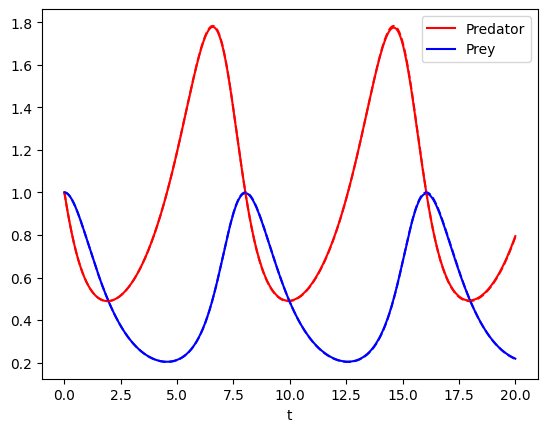

In [91]:
upinn.plot()